In [1]:
import rarfile
import numpy as np
inf=float("inf")

import random
from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.spatial as spatial

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit

import umap
import pickle

import os
import stablerank.srank as sr

from dtw import *

import fMRIanalysis.data as data
import fMRIanalysis.plotting as plotting

import time

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
med_info = pd.read_excel(r'data/Medicineinfo.xlsx').iloc[:,1].to_numpy()
med_indices = np.where(med_info == 1)[0]

range_of_subjects = range(1, 107)

colors = dict()
labels = dict()
counts = np.zeros(5)
i_ctr = []
i_pd_cn_med = []
i_pd_cn_nonmed = []
i_pd_mci_med = []
i_pd_mci_nonmed = []

for subject in range_of_subjects:
    if subject < 16:
        label = "CTR"
        color = 'k'
        counts[0] += 1
        i_ctr.append(subject)
    elif (subject >= 16 and subject < 88):
        if subject in med_indices:
            label = "PD_CN_med"
            color = 'y'
            counts[1] += 1
            i_pd_cn_med.append(subject)
        else:
            label = "PD_CN_nonMed"
            color = 'g'
            counts[2] += 1
            i_pd_cn_nonmed.append(subject)
    else:
        if subject in med_indices:
            label = "PD_MCI_med"
            color = 'r'
            counts[3] += 1
            i_pd_mci_med.append(subject)
        else:
            label = "PD_MCI_nonMed"
            color = 'm'
            counts[4] += 1
            i_pd_mci_nonmed.append(subject)
    labels[subject] = label
    colors[subject] = color
    
counts = [int(count) for count in counts]

# Split data set

In [3]:
range_of_subjects = range(1, 107)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=5)
split = sss.split([subject for subject in range_of_subjects], [labels[subject] for i in range_of_subjects])
train_index, val_index = next(iter(split))
train_subjects = train_index + 1
val_subjects = val_index + 1

train_counts = []
val_counts = []
for label in ['CTR', 'PD_CN_med', 'PD_CN_nonMed', 'PD_MCI_med', 'PD_MCI_nonMed']:
    train_counts.append([labels[subject] for subject in train_subjects].count(label))
    val_counts.append([labels[subject] for subject in val_subjects].count(label))
print(counts)
print(train_counts)
print(val_counts)

[15, 51, 21, 10, 9]
[7, 31, 15, 5, 5]
[8, 20, 6, 5, 4]


# Reference object = time series pasted after each other, each subject is a point in the reference object

In [4]:
fmri = dict()
for subject in train_subjects:
    fmri[subject] = data.TimeSeries(subject = subject).data_mat.flatten()
    
all_points = pd.DataFrame(np.vstack([fmri[subject] for subject in train_subjects]), index = train_subjects)

In [4]:
#scaler = MinMaxScaler()
#scaler.fit(all_points)
#scaled = scaler.fit_transform(all_points)
#all_points = pd.DataFrame(all_points, columns = all_points.columns)
#nr_of_features = len(all_points.columns)

In [5]:
all_points

,0,1,2,3,4,5,6,7,8,9,...,40990,40991,40992,40993,40994,40995,40996,40997,40998,40999
86,-1.279057,-1.377918,-2.061766,-0.863091,-2.762860,-1.903072,-1.842490,-3.201934,0.379197,-2.438398,...,0.721428,-5.404317,-0.121874,-3.510945,-4.922263,-3.698602,-7.037025,-4.130900,-4.034716,-6.613275
46,-1.544055,0.221873,-2.328774,-1.536002,-1.478573,-3.201951,-1.268583,-3.282221,-0.699002,-1.032536,...,0.906832,-1.473659,1.780708,-2.872796,0.951995,1.058131,2.574453,0.066154,-2.472883,2.401086
94,2.906554,-1.224310,-1.414364,0.607880,0.651387,2.386411,2.673619,-0.926393,5.917088,1.363121,...,-0.089470,-4.535823,0.345858,-5.638197,-3.987933,-1.491839,0.172648,-3.172222,-6.649505,0.141023
38,-0.544634,-0.967664,-1.972374,-1.661559,-0.896984,-2.335562,-3.752735,-1.845156,-1.165588,-1.799303,...,-0.604247,1.792049,1.031723,-0.103762,-0.162440,-1.052529,0.338182,0.153206,-3.081339,0.849716
104,-0.624507,-1.477985,-0.573447,-1.764180,-0.019766,0.811750,0.875336,0.725411,0.261640,-0.143806,...,0.101805,-4.051186,-0.078888,3.356025,-1.305647,0.624653,-1.739187,0.047800,0.493789,0.347256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,-0.814805,-0.083783,-0.083710,-0.792791,0.964794,-0.511130,-1.103106,-0.426554,0.998044,0.494904,...,-0.398904,1.679583,-0.161430,5.375708,0.668927,-0.325005,-0.119903,0.266458,1.688822,0.841727
12,-0.693840,-2.238716,1.268911,1.748907,-0.211209,2.214507,-0.668524,1.023298,-1.046561,-0.690282,...,0.007125,-0.169384,-0.264536,-0.664727,1.140951,0.079027,0.955608,-0.387460,-0.568406,0.200252
87,-1.487195,0.952570,2.292521,0.469527,0.414062,1.179644,4.237134,0.128567,1.042719,1.703249,...,-0.661339,0.520108,-0.941132,3.329282,1.785641,0.061040,1.013685,2.636779,0.283445,0.244706
7,0.784568,1.069240,2.143233,1.593653,1.157632,1.678979,-1.006418,3.019034,0.067603,-1.174280,...,-0.423477,-1.575907,-1.379632,0.169957,-1.999919,-0.349338,0.001907,1.108066,-0.506175,-0.601204


In [6]:
i_ctr_train = list(set(i_ctr) & set(train_subjects))

In [7]:
ctr_points = all_points.loc[i_ctr_train]
ctr_points

,0,1,2,3,4,5,6,7,8,9,...,40990,40991,40992,40993,40994,40995,40996,40997,40998,40999
4,-0.685274,1.360565,-1.460194,0.148369,-4.281788,-3.814491,-0.488871,-1.187928,-1.431247,-2.115506,...,1.126512,-2.658409,0.475298,-1.482328,-3.978599,-2.540399,-3.956510,-1.097153,-2.733472,-0.582962
7,0.784568,1.069240,2.143233,1.593653,1.157632,1.678979,-1.006418,3.019034,0.067603,-1.174280,...,-0.423477,-1.575907,-1.379632,0.169957,-1.999919,-0.349338,0.001907,1.108066,-0.506175,-0.601204
11,-0.365588,-0.015917,-0.018091,-0.022695,1.370830,0.936023,1.993368,0.905141,-2.043505,-1.282103,...,-1.282290,-3.111332,-1.452594,-10.330490,-0.683151,0.814790,-0.466000,0.528788,-3.878838,-0.671839
12,-0.693840,-2.238716,1.268911,1.748907,-0.211209,2.214507,-0.668524,1.023298,-1.046561,-0.690282,...,0.007125,-0.169384,-0.264536,-0.664727,1.140951,0.079027,0.955608,-0.387460,-0.568406,0.200252
13,0.024116,-2.858124,-1.906606,-0.185287,-2.082673,0.428736,1.463672,-1.545598,1.021298,1.562810,...,-2.580769,-4.689466,-0.909658,-4.047077,-3.892044,-0.013922,4.189511,0.435301,4.891567,2.556219
14,2.335205,1.448682,0.979013,2.601239,1.873480,-0.051698,-0.872749,0.398160,0.937905,4.407722,...,0.469196,-0.787880,0.816090,1.955103,-0.194518,-0.800198,0.773253,1.067912,-2.374524,1.023132
15,-3.582525,0.816696,-0.171013,-0.148302,-0.398382,-1.811409,2.871277,-2.914163,5.424574,4.413472,...,0.516104,-0.166096,0.114396,-0.693399,-4.132657,-0.034925,-2.638375,0.337745,1.178156,-1.523339


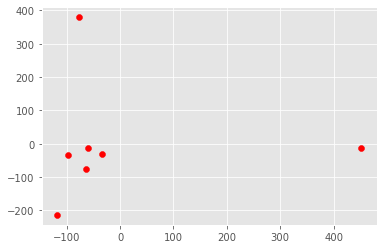

In [8]:
pca = PCA(n_components = 2)
pcs = pca.fit_transform(ctr_points)

plt.figure()
plt.scatter(pcs[:,0], pcs[:,1], color = "r")

In [9]:
sample_size = 30
number_instances = 50

hsr_subjects1 = dict()

ref_object = all_points 
cor_df = 1 - all_points.T.corr().abs()
d = sr.Distance(cor_df)

amplification = 80
k = 10
marge = (sample_size / 200) * amplification

for subject in tqdm(train_subjects):
    point = all_points.loc[subject]
    filt = sr.get_filter(point = point, ref_object = ref_object, metric = "euclidean")
    
    std = np.percentile(filt, k + marge) - np.percentile(filt, k)
    mean = np.percentile(filt, k)
    
    content = dict()
    content["name"] = "normal"
    content["m"] = mean
    content["sd"] = std    
    dist = sr.Distribution(content = content)
    probabilities = dist.evaluate(filt)
    sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = probabilities)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects1[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:15<00:00,  4.19it/s]


(0.0, 0.04)

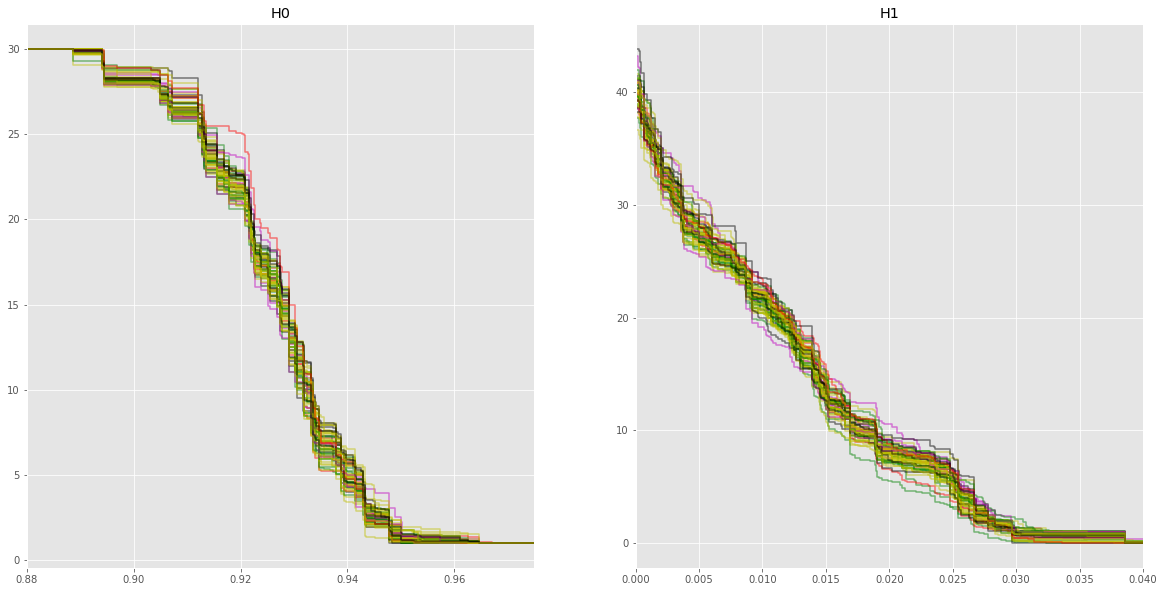

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in train_subjects:
    hsr_subjects1[subject][0].plot(ax = ax[0], color = colors[subject], alpha = 0.5)
    hsr_subjects1[subject][1].plot(ax = ax[1], color = colors[subject], alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.88, 0.975)
ax[1].set_xlim(0, 0.04)

# Reference object = 200 points in R^205, average over all controls

In [11]:
test_ref_obj = data.TimeSeries(subject = 1).data_mat.T
test_points = data.TimeSeries(subject = 16).data_mat.T

In [12]:
filt = np.zeros(200)

In [13]:
for i in range(200):
    filt[i] = spatial.distance.cdist([test_points[i]], [test_ref_obj[i]], metric = "euclidean")[0,0]

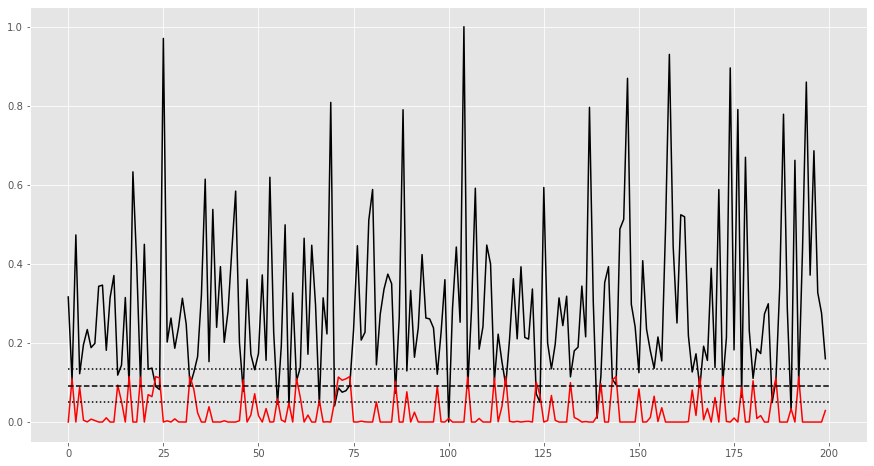

In [14]:
plt.figure(figsize = (15,8))
plt.plot((filt-np.min(filt))/(np.max(filt)-np.min(filt)), 'k')

amplification = 80
k = 10
marge = (sample_size / 200) * amplification

std = np.percentile(filt, k + marge) - np.percentile(filt, k)
mean = np.percentile(filt, k)

content = dict()
content["name"] = "normal"
content["m"] = mean
content["sd"] = std

dist = sr.Distribution(content = content)
prob = dist.evaluate(filt)

kthperc = (mean-np.min(filt))/(np.max(filt)-np.min(filt))
up = (mean-std-np.min(filt))/(np.max(filt)-np.min(filt))
low = (mean+std-np.min(filt))/(np.max(filt)-np.min(filt))

#plt.plot((prob-np.min(prob))/(np.max(prob)-np.min(prob)), 'r')
plt.plot(prob * 5, 'r')

plt.plot([0, 200], [kthperc, kthperc] , 'k--')
plt.plot([0, 200], [up, up] , 'k:')
plt.plot([0, 200], [low, low] , 'k:')

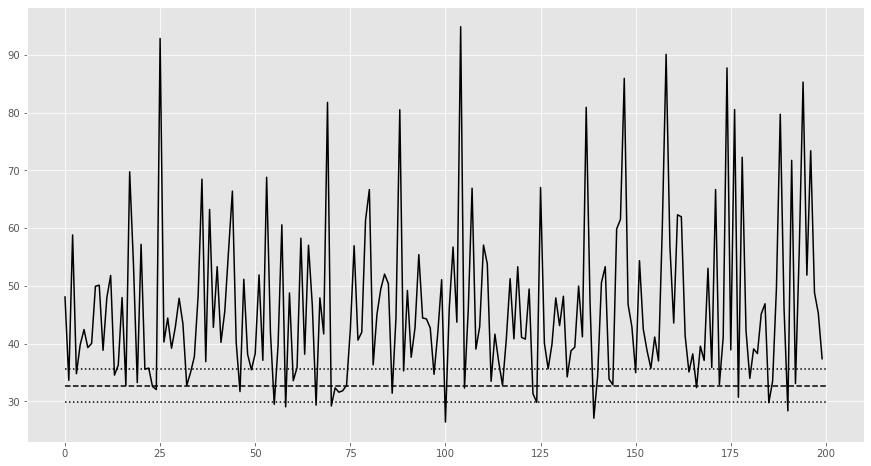

In [15]:
plt.figure(figsize = (15,8))
plt.plot(filt, 'k')

amplification = 80
k = 10
marge = (sample_size / 200) * amplification

std = np.percentile(filt, k + marge) - np.percentile(filt, k)
mean = np.percentile(filt, k)

content = dict()
content["name"] = "normal"
content["m"] = mean
content["sd"] = std

dist = sr.Distribution(content = content)
prob = dist.evaluate(filt)

plt.plot([0, 200], [mean, mean] , 'k--')
plt.plot([0, 200], [mean+std, mean+std] , 'k:')
plt.plot([0, 200], [mean-std, mean-std] , 'k:')

In [16]:
test_both = np.concatenate((test_ref_obj, test_points))

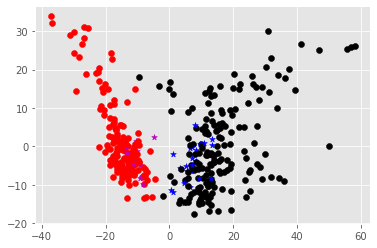

In [17]:
pca = PCA(n_components = 2)
pcs = pca.fit_transform(test_both)

plt.figure()
for i in range(200):
    if prob[i]  > 0.02:
        plt.scatter(pcs[i,0], pcs[i,1], color = "b", marker = '*')
        plt.scatter(pcs[i+200,0], pcs[i+200,1], color = "m", marker = '*')
    else:
        plt.scatter(pcs[i,0], pcs[i,1], color = "k")
        plt.scatter(pcs[i+200,0], pcs[i+200,1], color = "r")

## Compute stable ranks

## Unfiltered delayed Pearson, delay 1, abs, transpose multiplication

In [21]:
time_series_total = np.zeros((200, 205))
for subject in i_ctr_train:
    time_series_total = time_series_total + data.TimeSeries(subject = subject).data_mat.T
ref_obj = time_series_total / len(i_ctr_train)

data_mat_total = np.zeros((200, 200))
for subject in i_ctr_train:
    data_mat_total = data_mat_total + data.DistanceMatrix(subject = subject, 
                                                          method = "delayedPearson\\C200_delay1", 
                                                          neg_vals_method = "abs",
                                                          symmetrization = "transpose_multiplication").dist_mat
d = sr.Distance(data_mat_total / len(i_ctr_train))

correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1


In [22]:
number_of_instances = 50
sample_size = 30
amplification = 80
k = 10
marge = (sample_size / 200) * amplification

hsr_subjects2 = dict()
for subject in tqdm(train_subjects):
    points = data.TimeSeries(subject = subject).data_mat.T
    filt = np.zeros(200)
    for i in range(200):
        filt[i] = spatial.distance.cdist([points[i]], [ref_obj[i]], metric = "euclidean")[0,0]
    
    std = np.percentile(filt, k + marge) - np.percentile(filt, k)
    mean = np.percentile(filt, k)
    
    content = dict()
    content["name"] = "normal"
    content["m"] = mean
    content["sd"] = std

    dist = sr.Distribution(content = content)
    probabilities = dist.evaluate(filt)
    sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = probabilities)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects2[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.30it/s]


(0.0, 0.06)

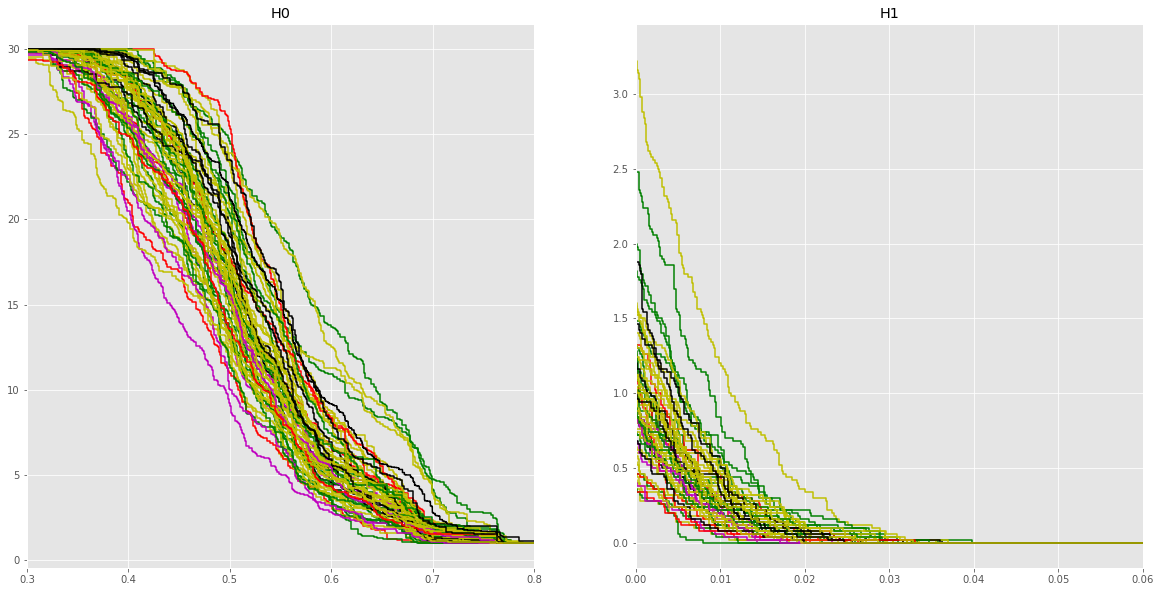

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in train_subjects:
    hsr_subjects2[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
    hsr_subjects2[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)
    
#for subject in range(1,16):
#    hsr_subjects2[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
#    hsr_subjects2[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.3, 0.8)
ax[1].set_xlim(0, 0.06)

## Filtered delayed Pearson, delay 1, abs, transpose multiplication

In [26]:
time_series_total = np.zeros((200, 205))
for subject in i_ctr_train:
    time_series_total = time_series_total + data.TimeSeries(subject = subject).data_mat.T
ref_obj = time_series_total / len(i_ctr_train)

data_mat_total = np.zeros((200, 200))
for subject in i_ctr_train:
    data_mat_total = data_mat_total + data.DistanceMatrix(subject = subject, 
                                                          method = "filtered_delayedPearson\\FDP_delay1", 
                                                          neg_vals_method = "abs",
                                                          symmetrization = "transpose_multiplication").dist_mat
d = sr.Distance(data_mat_total / len(i_ctr_train))

correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1


In [27]:
number_of_instances = 50
sample_size = 30
amplification = 80
k = 10
marge = (sample_size / 200) * amplification

hsr_subjects3 = dict()
for subject in tqdm(train_subjects):
    points = data.TimeSeries(subject = subject).data_mat.T
    filt = np.zeros(200)
    for i in range(200):
        filt[i] = spatial.distance.cdist([points[i]], [ref_obj[i]], metric = "euclidean")[0,0]
    
    std = np.percentile(filt, k + marge) - np.percentile(filt, k)
    mean = np.percentile(filt, k)
    
    content = dict()
    content["name"] = "normal"
    content["m"] = mean
    content["sd"] = std

    dist = sr.Distribution(content = content)
    probabilities = dist.evaluate(filt)
    sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = probabilities)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects3[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.82it/s]


(0.0, 0.07)

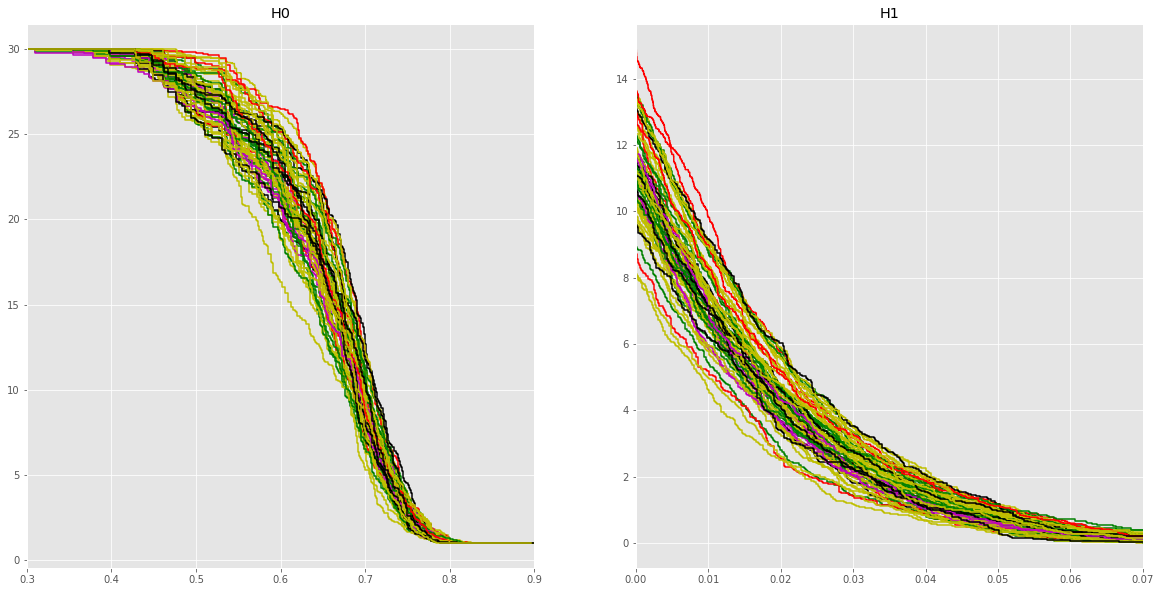

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in train_subjects:
    hsr_subjects3[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
    hsr_subjects3[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)
    
#for subject in range(1,16):
#    hsr_subjects2[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
#    hsr_subjects2[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.3, 0.9)
ax[1].set_xlim(0, 0.07)

## filtered_dtw, abs, transpose_multiplication

In [29]:
time_series_total = np.zeros((200, 205))
for subject in i_ctr_train:
    time_series_total = time_series_total + data.TimeSeries(subject = subject).data_mat.T
ref_obj = time_series_total / len(i_ctr_train)

data_mat_total = np.zeros((200, 200))
for subject in i_ctr_train:
    data_mat_total = data_mat_total + data.DistanceMatrix(subject = subject, 
                                                          method = "filtered_dtw", 
                                                          neg_vals_method = "abs",
                                                          symmetrization = "transpose_multiplication").dist_mat
d = sr.Distance(data_mat_total / len(i_ctr_train))

In [30]:
number_of_instances = 200
sample_size = 30
amplification = 20
k = 10
marge = (sample_size / 200) * amplification

hsr_subjects4 = dict()
for subject in tqdm(train_subjects):
    points = data.TimeSeries(subject = subject).data_mat.T
    filt = np.zeros(200)
    for i in range(200):
        filt[i] = spatial.distance.cdist([points[i]], [ref_obj[i]], metric = "euclidean")[0,0]
    
    std = np.percentile(filt, k + marge) - np.percentile(filt, k)
    mean = np.percentile(filt, k)
    
    content = dict()
    content["name"] = "normal"
    content["m"] = mean
    content["sd"] = std

    dist = sr.Distribution(content = content)
    probabilities = dist.evaluate(filt)
    sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = probabilities)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects4[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.63it/s]


(0.0, 0.025)

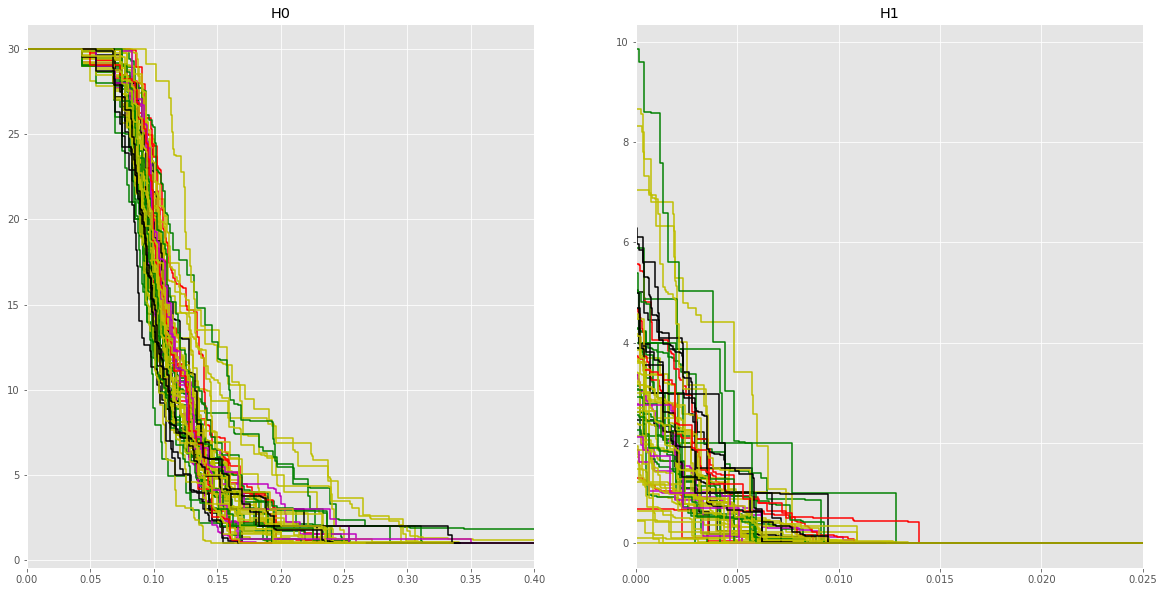

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in train_subjects:
    hsr_subjects4[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
    hsr_subjects4[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)
    
#for subject in range(1,16):
#    hsr_subjects2[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
#    hsr_subjects2[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0, 0.4)
ax[1].set_xlim(0, 0.025)

### Investigate whether all subjects have the same order of magnitude of their time series

In [32]:
maxVals = []
minVals = []
meanVals = []

for subject in range_of_subjects:
    maxVals.append(data.TimeSeries(subject = subject).data_df.max().max())
    minVals.append(data.TimeSeries(subject = subject).data_df.min().min())
    meanVals.append(data.TimeSeries(subject = subject).data_df.mean().mean())

In [33]:
data.TimeSeries(subject = subject).data_df.T

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,-2.478830,-1.411820,0.381083,0.759496,-0.058437,-0.237631,0.050826,0.846521,0.907006,1.319235,...,-1.760027,-2.301923,-2.328981,-0.997090,-0.699075,-2.720435,-0.385967,0.121130,-0.768908,-0.303587
1,-2.681632,-0.429266,2.298086,2.548347,-0.903932,-1.134227,0.253466,2.456229,2.996039,3.093184,...,-5.207838,-4.802327,-2.694561,1.710042,2.925646,0.520058,2.533748,-0.912507,-2.892548,-1.976033
2,-1.701183,-0.451555,1.605990,2.745506,1.038298,0.646013,1.274247,1.369934,-0.687881,-1.883348,...,-4.542023,-5.610173,-3.799044,-0.325909,2.902711,0.093183,1.160998,-2.079692,-2.395478,-0.239604
3,1.107895,3.464175,5.662491,3.556530,-1.274913,-2.634827,-0.706234,2.375216,1.820242,2.202096,...,-1.098033,-1.055357,-0.001661,0.565925,5.562402,-1.132098,-0.765501,-1.981033,-0.689770,1.452425
4,-1.433596,0.205902,1.438238,3.347953,3.212478,1.790500,0.435706,-0.896385,-2.027770,-2.401509,...,-0.056165,-0.668731,-0.549706,1.832921,2.521731,0.146456,-0.109495,-0.764480,-3.484163,-2.959666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.566713,2.919975,5.795421,5.351728,0.321852,-1.493466,-0.582837,2.222955,2.120612,2.205469,...,-1.123594,-2.158960,-2.494145,-1.355985,2.980866,-1.532653,-0.354110,-1.317085,-3.947123,-3.128443
196,-4.396139,-2.617023,-0.961330,0.565067,0.651757,3.156315,4.122295,2.557853,-1.983762,-4.164443,...,-7.574363,-8.054800,-4.907930,0.352357,-1.056256,-3.589828,-0.651485,-0.859112,-0.498207,2.713363
197,0.209746,-0.441499,-0.200460,0.409826,-0.269536,-0.938001,-0.983848,-0.180598,0.287707,2.661778,...,-1.083283,-1.391280,-1.659889,-2.206023,1.680925,-1.429178,0.421592,1.571200,2.176074,0.775512
198,-1.757602,-0.780193,1.517692,1.202113,-3.243219,-6.496869,-3.225283,3.015332,4.762218,6.254016,...,4.905310,4.264081,1.283622,-1.451409,6.160030,1.401534,4.405891,-0.773494,-6.549711,-6.826514


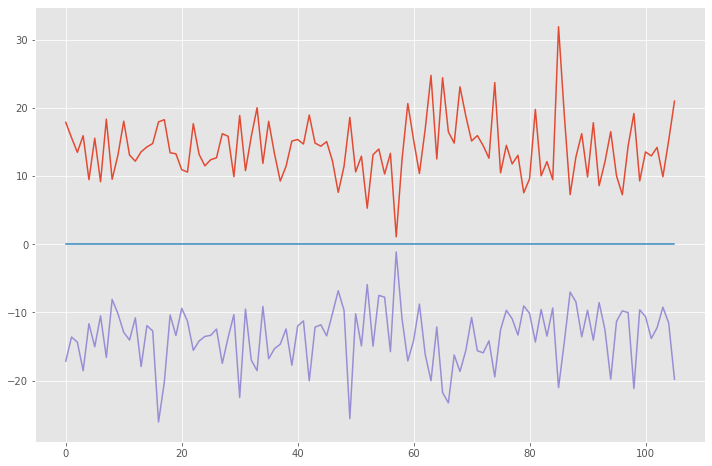

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(maxVals)
plt.plot(meanVals)
plt.plot(minVals)

# Normalized time series

In [35]:
norm_TimeSeries = dict()
for subject in range_of_subjects:
    ts = data.TimeSeries(subject = subject).data_mat.T
    maxVal = np.max(ts)
    minVal = np.min(ts)
    norm_TimeSeries[subject] = (ts - minVal) / (maxVal - minVal)

In [36]:
time_series_total = np.zeros((200, 205))
for subject in i_ctr_train:
    time_series_total = time_series_total + norm_TimeSeries[subject]
ref_obj = time_series_total / len(i_ctr_train)

data_mat_total = np.zeros((200, 200))
for subject in i_ctr_train:
    data_mat_total = data_mat_total + data.DistanceMatrix(subject = subject, 
                                                          method = "filtered_delayedPearson\\FDP_delay1", 
                                                          neg_vals_method = "abs",
                                                          symmetrization = "transpose_multiplication").dist_mat
d = sr.Distance(data_mat_total / len(i_ctr_train))

correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1


In [37]:
number_of_instances = 50
sample_size = 30
amplification = 80
k = 10
marge = (sample_size / 200) * amplification

hsr_subjects5 = dict()
for subject in tqdm(train_subjects):
    points = norm_TimeSeries[subject]
    filt = np.zeros(200)
    for i in range(200):
        filt[i] = spatial.distance.cdist([points[i]], [ref_obj[i]], metric = "euclidean")[0,0]
    
    std = np.percentile(filt, k + marge) - np.percentile(filt, k)
    mean = np.percentile(filt, k)
    
    content = dict()
    content["name"] = "normal"
    content["m"] = mean
    content["sd"] = std

    dist = sr.Distribution(content = content)
    probabilities = dist.evaluate(filt)
    sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = probabilities)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects5[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.79it/s]


(0.0, 0.07)

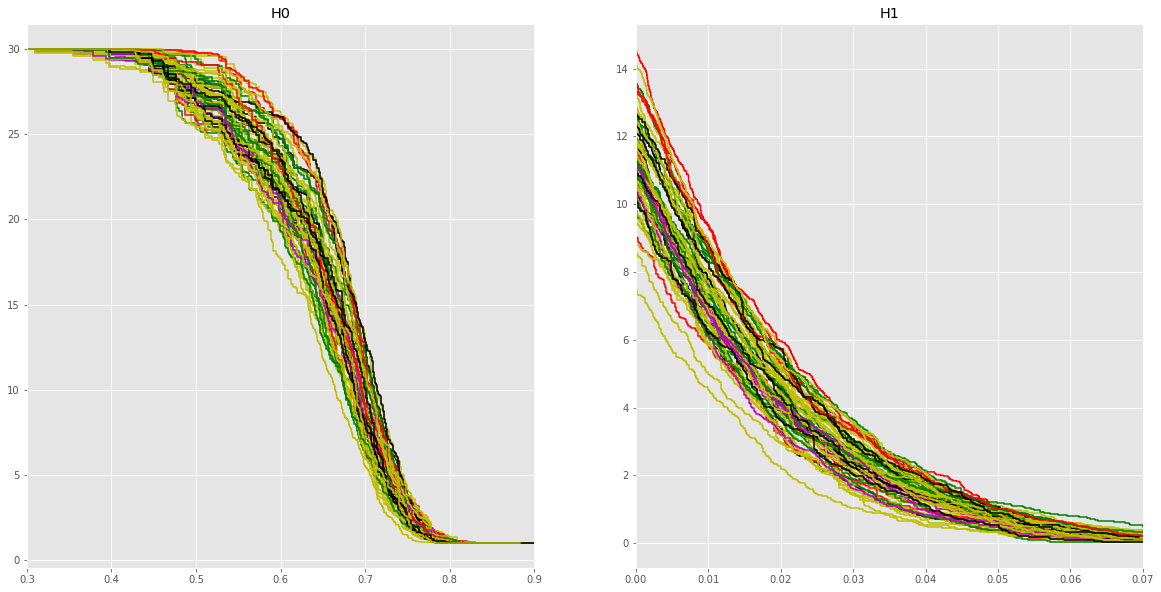

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in train_subjects:
    hsr_subjects5[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
    hsr_subjects5[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)
    
#for subject in range(1,16):
#    hsr_subjects2[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
#    hsr_subjects2[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.4, 0.8)
ax[1].set_xlim(0, 0.07)

# Filter computation based on correlation

In [42]:
time_series_total = np.zeros((200, 205))
for subject in i_ctr_train:
    time_series_total = time_series_total + norm_TimeSeries[subject]
ref_obj = time_series_total / len(i_ctr_train)

data_mat_total = np.zeros((200, 200))
for subject in i_ctr_train:
    data_mat_total = data_mat_total + data.DistanceMatrix(subject = subject, 
                                                          method = "filtered_delayedPearson\\FDP_delay1", 
                                                          neg_vals_method = "abs",
                                                          symmetrization = "transpose_multiplication").dist_mat
d = sr.Distance(data_mat_total / len(i_ctr_train))

correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1
correlation values exceed 1, normalizing matrix between 0 and 1


In [56]:
number_of_instances = 50
sample_size = 30
amplification = 80
k = 10
marge = (sample_size / 200) * amplification

hsr_subjects6 = dict()
for subject in tqdm(train_subjects):
    points = norm_TimeSeries[subject]
    filt = np.zeros(200)
    for i in range(200):
        filt[i] = pd.DataFrame([points[i], ref_obj[i]]).T.corr().loc[0,1] 
        #filt[i] = spatial.distance.cdist([points[i]], [ref_obj[i]], metric = "euclidean")[0,0]
    
    std = np.percentile(filt, k + marge) - np.percentile(filt, k)
    mean = np.percentile(filt, k)
    
    content = dict()
    content["name"] = "normal"
    content["m"] = mean
    content["sd"] = std

    dist = sr.Distribution(content = content)
    probabilities = dist.evaluate(filt)
    sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = probabilities)
    barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
    hsr_subjects6[subject] = (sr.bc_to_sr(barcode, degree = "H0"), sr.bc_to_sr(barcode, degree = "H1")) 

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:48<00:00,  1.72s/it]


(0.0, 0.07)

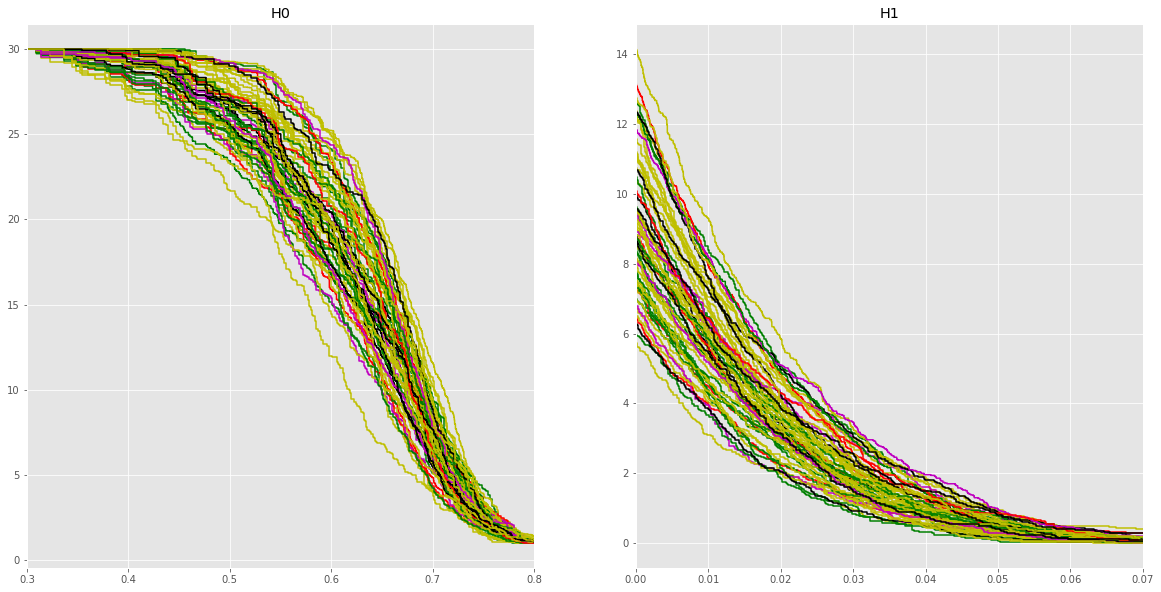

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#fig.suptitle("Filtered, symmetrization: antisymmetric part", fontsize=18) 

for subject in train_subjects:
    hsr_subjects6[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
    hsr_subjects6[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)
    
#for subject in range(1,16):
#    hsr_subjects2[subject][0].plot(ax = ax[0], color = colors[subject])#, alpha = 0.5)
#    hsr_subjects2[subject][1].plot(ax = ax[1], color = colors[subject])#, alpha = 0.5)

ax[0].set_title("H0")
ax[1].set_title("H1")
ax[0].set_xlim(0.3, 0.8)
ax[1].set_xlim(0, 0.07)